# Binary and Categorical classification 

## 1. Dataset Preparation
### 1-1. Dataset loading


* the spam mail dataset for binary classification : https://archive.ics.uci.edu/ml/datasets/spambase 
* the wine dataset for categorical classification : https://archive.ics.uci.edu/ml/datasets/wine 

When running with pytorch, samples should be stored as datatype ``torch.tensor``, and split between input sets $\mathbf X = [\vec x^{[1]}, \ldots, \vec x^{[N]}]^T \in \mathbb R^{N\times D}$ and targets.
*  for binary classifier: $\mathbf T = [[t^{[1]}, \ldots, t^{[N]}]] \in \mathbb R^{N\times1} $ and of type ``torch.float`` 
* for categorical classification : the class indexes $\vec t = [t^{[1]}, \ldots, t^{[N]}]$ to be in dimension $\mathbb N^N$ and of type ``torch.long``.


In [18]:
import os
import csv

# download the two dataset files
dataset_files = {
  "spambase.data": "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/",
  "wine.data": "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/"
}
for name, url in dataset_files.items():
  if not os.path.exists(name):
    import urllib.request
    urllib.request.urlretrieve(url+name, name)
    print ("Downloaded datafile", name)


In [19]:
def dataset(dataset_file="wine.data"):
  # read dataset
  data = []
  with open(dataset_file, 'r') as f:
    for row in csv.reader(f):
      if row:
        data.append([float(x) for x in row])

  print (f"Loaded dataset with {len(data)} samples")
  
  # convert to torch.tensor
  data = torch.tensor(data)

  if dataset_file == "wine.data":
    # target is in the first column and needs to be converted to long
    X = data[:,1:]
    T = data[:,0].type(torch.long) - 1 # convert to 0 to O-1 => (0,1,2)
  else:
    # target is in the last column and needs to be of type float
    X = data[:,:-1]
    T = data[:,-1:] # slicing tips
  return X, T

#### TEST 1
1. load wine dataset
* check dataset dimention (i.e., $\mathbf X\in \mathbb R^{N\times D}$ and $\mathbf T \in \mathbb N^N$)
* check all targets (class labels) are in the correct range $[0, O-1]$
2. load spam dataset  
* check dataset dimension
* check all targets are in correct range $\{0, 1\}$

In [ ]:
# load wine data
X, T = dataset("wine.data")
# assert that everything is correct with the dataset
print(X[0], T[0])
assert X.shape[1] == 13
assert torch.all(T>=0) and torch.all(T<=2)
assert T.dtype == torch.long


In [29]:
# load email data
X, T = dataset("spambase.data")
# assert that everything is correct with the dataset
assert X.shape[1] == 57
assert T.shape[1] == 1
assert torch.all(T>=0) and torch.all(T<=1)
assert T.dtype == torch.float


Loaded dataset with 4601 samples


### 1-2. split dataset

randomly split 80% of the data for training, and 20% for validation.


In [20]:
import random 

def split_data(X,T,ratio=0.8):
  # compute num of trainset from given ratio
  train_ratio = int(len(X)*ratio)

  # create shuffled index
  indexes = list(range(len(X)))
  random.seed(1979)
  random.shuffle(indexes)

  # split datasets
  X_train = X[indexes[:train_ratio]]
  T_train = T[indexes[:train_ratio]]

  X_val = X[indexes[train_ratio:]]
  T_val = T[indexes[train_ratio:]]

  return X_train, T_train, X_val, T_val 



### 1-3. Data Normalization 
Standardizes all input data for both the training and validation set

In [21]:
def standardize(X_train, X_val):
  # compute statistics
  mean = torch.mean(X_train, axis=0)
  std = torch.mean(X_train, axis=0)

  # standardize both X_train and X_val
  X_train = (X_train - mean)/std
  X_val = (X_val - mean)/std

  return X_train, X_val

## 2. Network (Classifier) implementation

implement both classifier with a two-layer fully-connected network in pytorch.  
 $tanh$ is used for activation function

In [53]:
import torch

def network(D, K, O):
  return torch.nn.Sequential(
    torch.nn.Linear(D,K),
    torch.nn.Tanh(),
    torch.nn.Linear(K,O)
  )


## 3. Accuracy function
a function that computes the accuracy of the provided network output (the logits) and the given target values. the function works for both binary as well as categorical targets.

In [23]:
def accuracy(Z,T):
  if Z.shape[1] == 1:
    # if binary target:
    return torch.mean(((Z>0)==T).type(torch.float))
  else:
    # if categorical target:
    return torch.mean((torch.argmax(Z,dim=1)==T).type(torch.float))

In [24]:
# test binary classification

ZZ = torch.ones((20,1))*-5 # T = 0
ZZ[15:20] = 5 # T = 1 

assert(abs(accuracy(ZZ,torch.zeros((20,1)))-0.75) < 1e-8)
assert(abs(accuracy(ZZ,torch.ones((20,1)))-0.25) < 1e-8)

In [25]:
# test categorical classification 

# one-hot encoding
ZZ = torch.ones((20,4))*-5
ZZ[0:1,0] = 5
ZZ[1:4,1] = 5
ZZ[4:10,2] = 5
ZZ[10:20,3] = 5

assert(abs(accuracy(ZZ,torch.tensor((0,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3)))-1) < 1e-8)

## 4. Compute loss and accuracy

* training with batch gradient descent for whole dataset `torch.optim.SGD`
* For each epoch, store accuracy and loss of train and validation set 

In [35]:
def compute_loss_acc(X_train,T_train,X_val,T_val,loss,epochs=10000,eta=0.1):

  optimizer = torch.optim.SGD(params=network.parameters(),lr=eta)
  train_loss, train_acc, val_loss, val_acc = [], [], [], []

  for epoch in range(epochs):

    # train on training set
    # 1. initialize optimizer
    optimizer.zero_grad()
    # 2. compute network output on training data
    Z = network(X_train)
    # 3. compute loss from network output and target data
    J = loss(Z, T_train)
    J.backward()
    # 4. perform parameter update
    optimizer.step()
    # 5. store loss and accuracy
    train_loss.append(J.item())
    train_acc.append(accuracy(Z, T_train))

    # test on validation data
    with torch.no_grad():
      # 1. compute network output on validation data
      Z = network(X_val)
      # 2. compute loss from network output and target data
      J = loss(Z, T_val)
      # 3. store loss and accuracy
      val_loss.append(J.item())
      val_acc.append(accuracy(Z, T_val))

  return train_loss, train_acc, val_loss, val_acc

## 5. plot function

In [36]:
from matplotlib import pyplot

def plot(train_loss, train_acc, val_loss, val_acc):
  pyplot.figure(figsize=(10,3))
  ax = pyplot.subplot(121)
  ax.plot(train_loss, "g-", label="Training set loss")
  ax.plot(val_loss, "b-", label="Validation set loss")
  ax.set_xlabel("Epoch")
  ax.legend()

  ax = pyplot.subplot(122)
  ax.plot(train_acc, "g-", label="Training set accuracy")
  ax.plot(val_acc, "b-", label="Validation set accuracy")
  ax.set_xlabel("Epoch")
  ax.legend()

## 5. Run Binary classification
1. Load the data for binary classification, using the ``"spambase.data"`` file.
2. Split the data into training and validation sets.
Standardize both training and validation input data.
3. Instantiate a network with the correct number of input neurons $D$, a given number of $K$ hidden neurons and one output neuron $O$.
4. Instantiate the binary cross entropy loss function: `torch.nn.BCEWithLogitsLoss()`
5. Train the network with data for 10'000 epochs 
6. plot the training and validation accuracies and losses.

Loaded dataset with 4601 samples
57 50 1


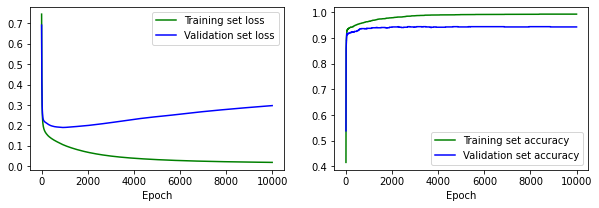

In [46]:
# 1. load dataset
X, T = dataset("spambase.data")

# 2. split dataset
X_train, T_train, X_val, T_val = split_data(X,T,0.8)

# 3. standardize input data
X_train, X_val = standardize(X_train, X_val)

# 4. define loss function for binary classification
loss = torch.nn.BCEWithLogitsLoss()

# 5. instantiate network
D,K,O=X_train.shape[1],50,1
network = network(D,K,O)

# train network on our data
results = compute_loss_acc(X_train,T_train,X_val, T_val,loss)

# plot the results
plot(*results)

## 6. Run Categorical classification
1. Load the data for categorical classification, using the "wine.data" file.
2. Split the data into training and validation sets. 
3. Standardize both training and validation input data.
4. Instantiate a network with the correct number of input neurons  𝐷 , a given number of  𝐾  hidden neurons and one output neuron  𝑂 .
5. Instantiate the categotical cross entropy loss function.
6. Train the network with data for 10'000 epochs
7. plot the training and validation accuracies and losses.

Loaded dataset with 178 samples


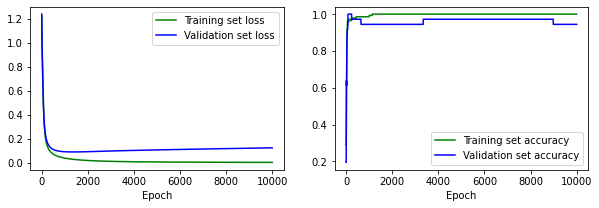

In [54]:
# 1. load dataset
X, T = dataset("wine.data")

# 2. split dataset
X_train, T_train, X_val, T_val = split_data(X,T,0.8)

# 3. standardize input data
X_train, X_val = standardize(X_train, X_val)

# 4. define loss function for binary classification
loss = torch.nn.CrossEntropyLoss()

# 5. instantiate network
D,K,O=X_train.shape[1],2,3
network = network(13,2,3)

# train network on our data
results = compute_loss_acc(X_train,T_train,X_val, T_val,loss)

# plot the results
plot(*results)